# 0４. データを結合する

【このノートで実施すること】</br>
　kyiデータとsedデータを結合し、機械学習用のデータを作成します。</br>
</br>
【入力】</br>
　・data/03_preprocessed_data/df_kyi.plk</br>
　・data/03_preprocessed_data/df_sed.plk</br>
</br>
【出力】</br>
　・data/04_merged_data/df_merged.pkl</br>
</br>

## 04.1. 準備

必要なモジュールをインポートしたり、データを読み込んだり、カラムに接頭辞をつけて出典データがわかるようにしています。

In [ ]:
# 必要なモジュールをインポート
import pandas as pd
import pickle
import os
from tqdm import tqdm

In [ ]:
# 全カラム、全レコードを表示するように設定
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# kyiデータを読み込む
with open('data/03_preprocessed_data/df_kyi.pkl', 'rb') as file:
    df_kyi = pickle.load(file)

In [ ]:
# sedデータを読み込む
with open('data/03_preprocessed_data/df_sed.pkl', 'rb') as file:
    df_sed = pickle.load(file)

In [ ]:
# カラム名に接頭辞を追加
prefix = 'KYI_'
df_kyi.columns = [prefix + col for col in df_kyi.columns]

In [ ]:
# カラム名に接頭辞を追加
prefix = 'SED_'
df_sed.columns = [prefix + col for col in df_sed.columns]

In [ ]:
# kyiデータの確認
df_kyi.head()

In [ ]:
# sedデータの確認
df_sed.head()

## 04.2. kyiデータに着順を追加

sedデータを参照して、そのレースの馬の着順を追加します。<br>
これが今回の機械学習の目的変数にあたります。<br>

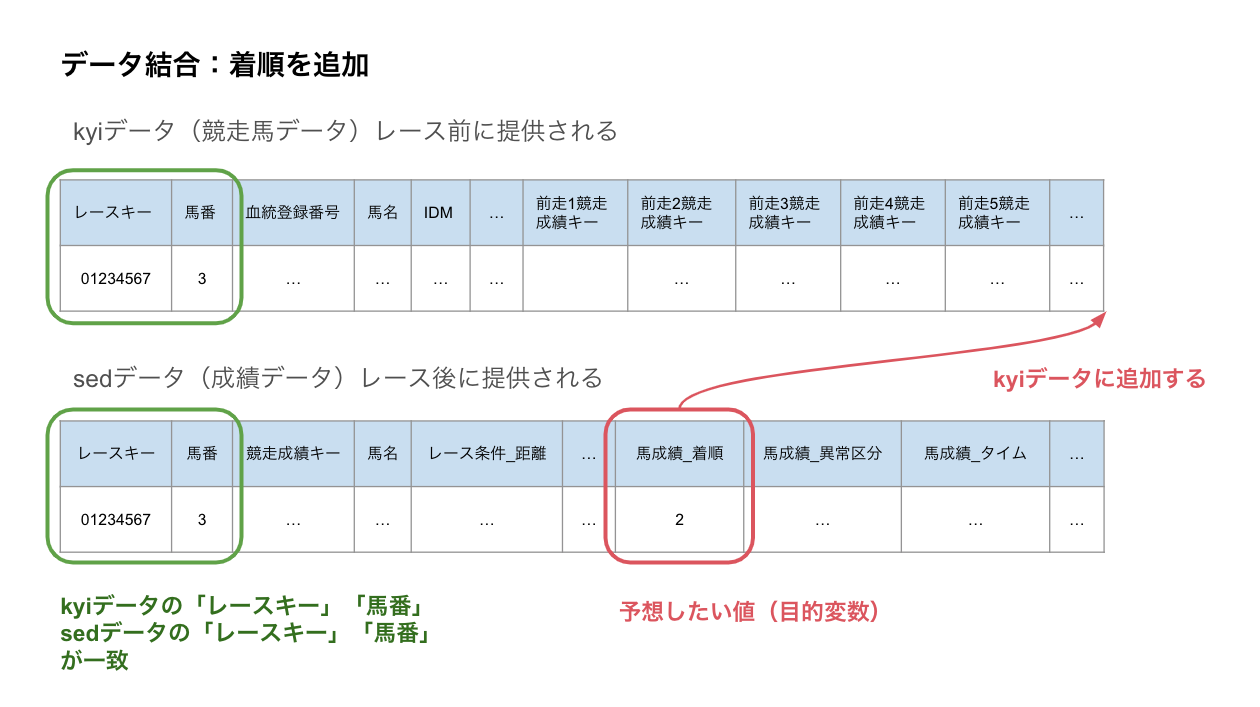

In [ ]:
# sedデータから、結合に必要なカラムを抽出
df_sed_subset = df_sed[['SED_レースキー', 'SED_馬番', 'SED_馬成績_着順']]
# データを結合し、不要なカラムを削除
df_kyi_with_position = df_kyi.merge(df_sed_subset, left_on=['KYI_レースキー', 'KYI_馬番'], right_on=['SED_レースキー', 'SED_馬番'], how='left')
df_kyi_with_position = df_kyi_with_position.drop(['SED_レースキー', 'SED_馬番'], axis=1)

In [ ]:
# 結合したデータのレコードを確認
# 「SED_馬成績_着順」が追加されているはずです
df_kyi_with_position.head()

In [ ]:
# 結合したデータの基本情報を確認
# 「SED_馬成績_着順」が追加されているはずです
df_kyi_with_position.info()

## 04.3. kyiデータに過去の成績データを追加

sedデータを参照して、その馬の過去の成績（前走〜５走前まで）を取得します。<br>
これにより、kyiデータ（今回のレースの前情報）だけでレースの着順を予測するよりも予測精度が向上することが期待できます。<br>

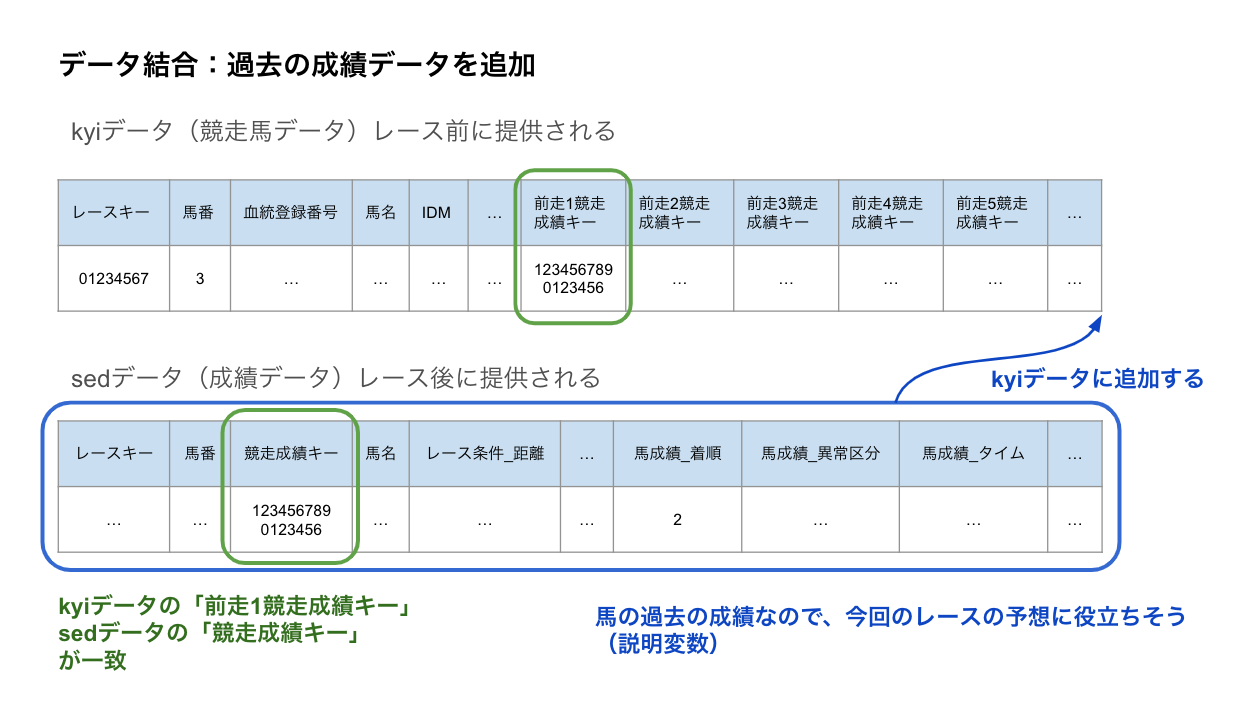

前走1競走成績キーと同様に、前走2〜5の競走成績キーを参照してデータを結合します。<br>
これにより、前走〜5走前までの成績データを結合できます。<br>

In [ ]:
# kyiデータに過去の成績データを結合するメソッド
def merge_past_race_results_to_kyi(df_kyi, df_sed):
    df_merged_all = pd.DataFrame()
    df_merged = df_kyi.copy()

    for i in tqdm(range(1, 6), desc="Processing files"):
        kyi_key_col = f'KYI_他データリンク用キー_前走{i}競走成績キー'
        sed_prefix = f'SED_{i}走前_'
        sed_key_col = sed_prefix + '競走成績キー'

        # データを複製
        df_sed_copy = df_sed.copy()

        # sedデータのカラム名を更新
        df_sed_copy = df_sed_copy.rename(columns=lambda x: x.replace('SED_', sed_prefix))

        # 条件に合致する行を結合
        df_merged = df_merged.merge(df_sed_copy, left_on=[kyi_key_col], right_on=[sed_key_col], how='left')

    return df_merged

In [ ]:
# 結合を実施
df_merged =  merge_past_race_results_to_kyi(df_kyi_with_position, df_sed)

In [ ]:
# 結合したデータのレコードを確認
# 「SED_１走前_」〜「SED_5走前_」の各カラムが追加されているはずです
df_merged.head()

In [ ]:
# 結合したデータの基本情報を確認
# 「SED_１走前_」〜「SED_5走前_」の各カラムが追加されているはずです
df_merged.info()

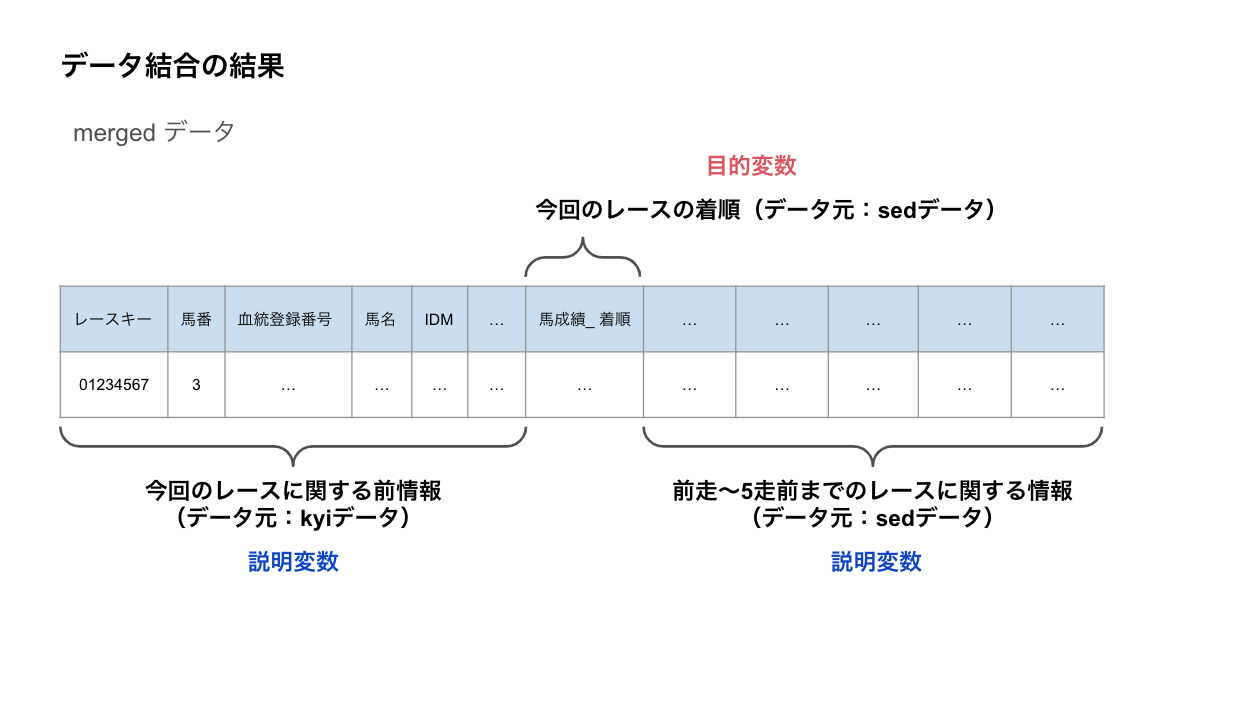

最終的にこのようなデータになっているはずです。<br>
これ以降の処理では、今回のレースに関する前情報、および、前走〜5走前までのレースに関する情報 をもとに、<br>
今回のレースの着順 を予想していきます。<br>
<br>
実際には、今回のレースに関する前情報、および、前走〜5走前までのレースに関する情報　の中から機械学習に有効そうなカラムだけ抽出し、<br>
機械学習モデルに読み込ませて学習させることになります。<br>
抽出作業は次のノートブックで実施します。<br>

## 04.4. データを保存する

結合したデータを保存します。

In [ ]:
# ファイルをpickle形式で保存する
def save_dataframe_to_pickle(dataframe, folder_path, file_name):
    
    print("結合したデータをファイルに保存します")

    # フォルダが存在しない場合は作成
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # ファイルのフルパスを構築
    file_path = os.path.join(folder_path, file_name + ".pkl")

    # DataFrame を pickle 形式で保存
    with open(file_path, 'wb') as file:
        pickle.dump(dataframe, file)

    print("保存しました")

In [ ]:
dataframe = df_merged
folder_path = "data/04_merged_data"
file_name = "df_merged"
save_dataframe_to_pickle(dataframe, folder_path, file_name)